## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

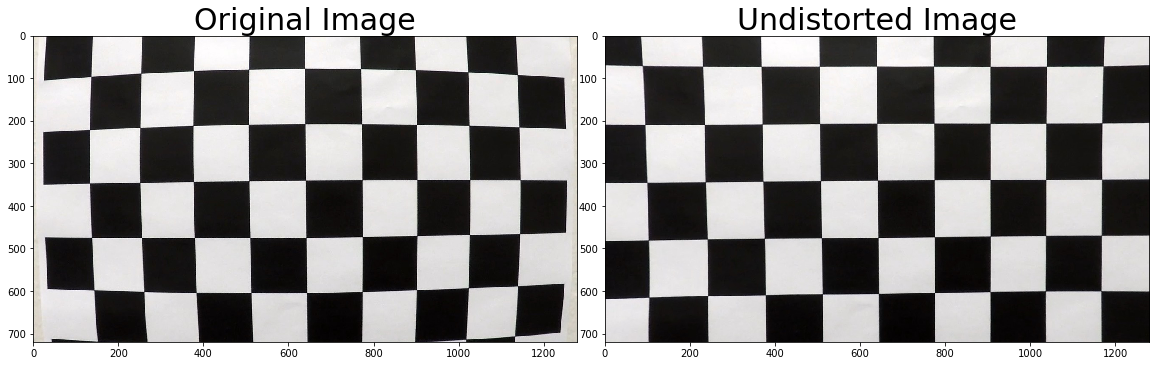

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib qt
%matplotlib inline

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('../camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = mpimg.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)
    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
img = mpimg.imread('../camera_cal/calibration1.jpg')
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, (img.shape[1], img.shape[0]), None, None)
undist = cv2.undistort(img, mtx, dist, None, mtx)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(undist)
ax2.set_title('Undistorted Image', fontsize=30)
print('')
        

## Apply distortion correction to a test image

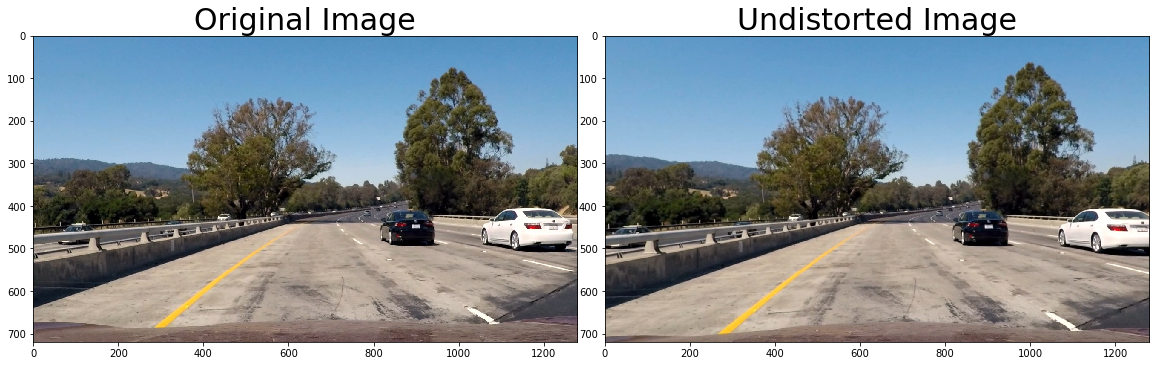

In [2]:
test1 = mpimg.imread('../test_images/test1.jpg')
undist_test1 = cv2.undistort(test1, mtx, dist, None, mtx)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(test1)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(undist_test1)
ax2.set_title('Undistorted Image', fontsize=30)
print('')

## Gradient and color thresholding

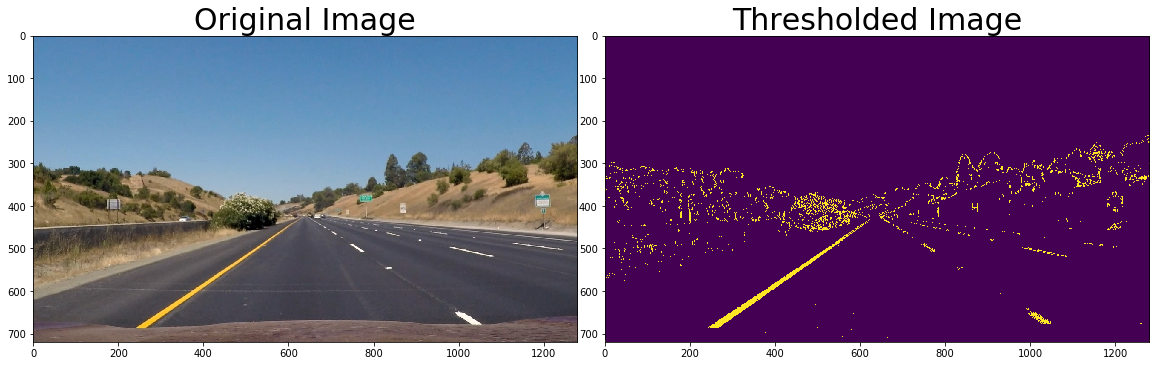

In [3]:
test2 = mpimg.imread('../test_images/straight_lines1.jpg')
def thresholding(img, s_thresh=(190, 255), sx_thresh=(35, 85)):
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    #color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1

    return combined_binary
    
result = thresholding(test2)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(test2)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(result)
ax2.set_title('Thresholded Image', fontsize=30)
print('')

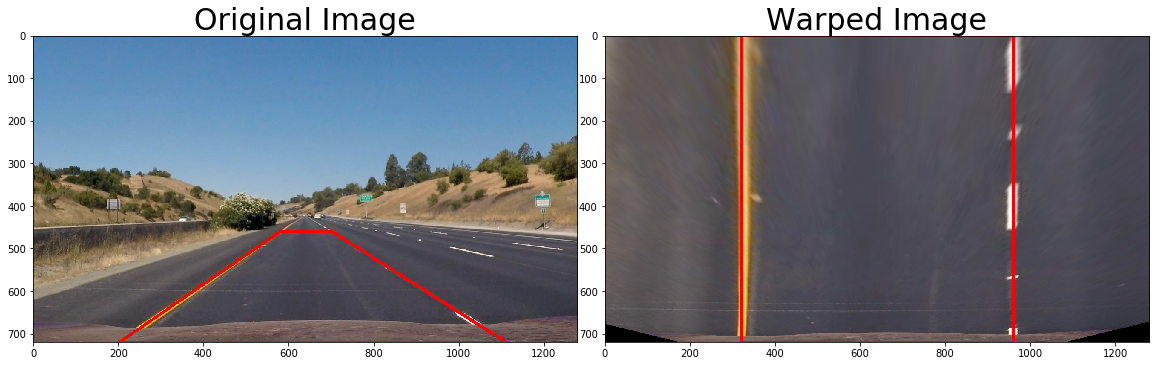

In [4]:


def warp(img):
    img = img.copy()
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    global img_size
    img_size = (gray.shape[1], gray.shape[0])
    global src
    global dst
    src = np.float32(
    [[(img_size[0] / 2) - 59, img_size[1] / 2 + 100],
    [((img_size[0] / 6) - 10), img_size[1]],
    [(img_size[0] * 5 / 6) + 45, img_size[1]],
    [(img_size[0] / 2 + 61), img_size[1] / 2 + 100]])
    dst = np.float32(
    [[(img_size[0] / 4), 0],
    [(img_size[0] / 4), img_size[1]],
    [(img_size[0] * 3 / 4), img_size[1]],
    [(img_size[0] * 3 / 4), 0]])
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, img_size)
    return warped
warped = warp(test2)
color=[255, 0, 0]
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.subplots_adjust(hspace = .2, wspace=.05)
cv2.polylines(test2, np.int32([src]), True, color, 5)
cv2.polylines(warped, np.int32([dst]), True, color, 5)
ax1.imshow(test2)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(warped)
ax2.set_title('Warped Image', fontsize=30)
print('')


## Fit lane lines with a polynomial

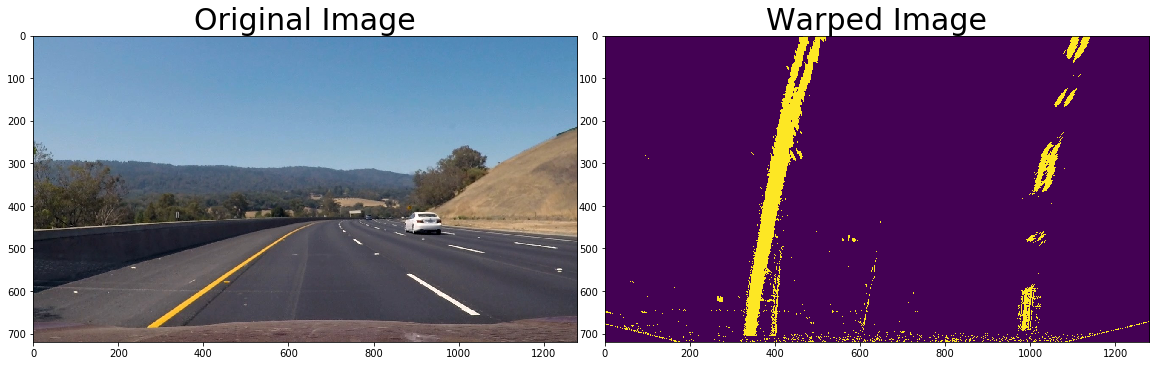

In [5]:
test3 = mpimg.imread('../test_images/test3.jpg')
warped3 = thresholding(warp(test3), (150, 255), (10, 120))
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(test3)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(warped3)
ax2.set_title('Warped Image', fontsize=30)
print('')


Vehicle is 0.206142857143m left of center
Radius of curvature is 849.972216069m


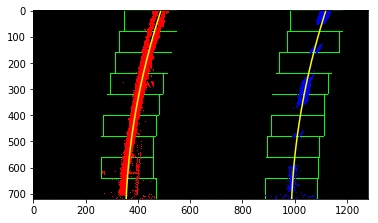

In [6]:
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        ### TO-DO: Find the four below boundaries of the window ###
        win_xleft_low = leftx_current - margin  # Update this
        win_xleft_high = leftx_current + margin  # Update this
        win_xright_low = rightx_current - margin  # Update this
        win_xright_high = rightx_current + margin  # Update this
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        ### TO-DO: Identify the nonzero pixels in x and y within the window ###
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        ### TO-DO: If you found > minpix pixels, recenter next window ###
        ### (`right` or `leftx_current`) on their mean position ###
         # Remove this when you add your function
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img, leftx_base, rightx_base


def fit_polynomial(binary_warped):
    # Find our lane pixels first
    
    leftx, lefty, rightx, righty, out_img, leftx_base, rightx_base = find_lane_pixels(binary_warped)

    ### TO-DO: Fit a second order polynomial to each using `np.polyfit` ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty
    
    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700
    left_A = xm_per_pix / (ym_per_pix**2) * left_fit[0]
    left_B = xm_per_pix / ym_per_pix * left_fit[1]
    right_A = xm_per_pix / (ym_per_pix**2) * right_fit[0]
    right_B = xm_per_pix / ym_per_pix * right_fit[1]
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_A*y_eval*ym_per_pix + left_B)**2)**1.5) / np.absolute(2*left_A)
    right_curverad = ((1 + (2*right_A*y_eval*ym_per_pix + right_B)**2)**1.5) / np.absolute(2*right_A)
    view_center = img_size[0] / 2
    lane_center = (leftx_base + rightx_base)/2
    if lane_center > view_center:
        print ("Vehicle is " + str((lane_center - view_center)*xm_per_pix) + "m left of center")
    else:
        print ("Vehicle is " + str((view_center - lane_center)*xm_per_pix) + "m right of center")
    print ("Radius of curvature is "+ str((left_curverad + right_curverad)/2) + "m")
    return out_img


out_img = fit_polynomial(warped3)

plt.imshow(out_img)

## Warp the warped image back to the original image

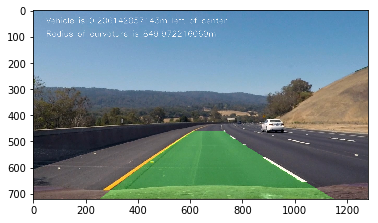

In [7]:
leftx, lefty, rightx, righty, out_img, leftx_base, rightx_base = find_lane_pixels(warped3)
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
def rewarp(original, warped, left_fit, right_fit, lane_center):
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700
    left_A = xm_per_pix / (ym_per_pix**2) * left_fit[0]
    left_B = xm_per_pix / ym_per_pix * left_fit[1]
    right_A = xm_per_pix / (ym_per_pix**2) * right_fit[0]
    right_B = xm_per_pix / ym_per_pix * right_fit[1]
    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
    y_eval = np.max(ploty)
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700
    left_A = xm_per_pix / (ym_per_pix**2) * left_fit[0]
    left_B = xm_per_pix / ym_per_pix * left_fit[1]
    right_A = xm_per_pix / (ym_per_pix**2) * right_fit[0]
    right_B = xm_per_pix / ym_per_pix * right_fit[1]
    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_A*y_eval*ym_per_pix + left_B)**2)**1.5) / np.absolute(2*left_A)
    right_curverad = ((1 + (2*right_A*y_eval*ym_per_pix + right_B)**2)**1.5) / np.absolute(2*right_A)
    view_center = img_size[0] / 2

    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, cv2.getPerspectiveTransform(dst, src), (original.shape[1], original.shape[0]))
# Combine the result with the original image
    result = cv2.addWeighted(original, 1, newwarp, 0.3, 0)
    if lane_center > view_center:
        result = cv2.putText(result, "Vehicle is " + str((lane_center - view_center)*xm_per_pix) + "m left of center", (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (255, 255, 255), lineType=cv2.LINE_AA)
    else:
        result = cv2.putText(result, "Vehicle is " + str((view_center - lane_center)*xm_per_pix) + "m right of center", (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (255, 255, 255), lineType=cv2.LINE_AA)
    result = cv2.putText(result, "Radius of curvature is "+ str((left_curverad + right_curverad)/2) + "m", (50, 100), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (255, 255, 255), lineType=cv2.LINE_AA)
    return result
    
plt.imshow(rewarp(test3, warped3, left_fit, right_fit, (leftx_base + rightx_base)/2))

## Fit polynomial lines for a movie

In [8]:
def search_around_poly(binary_warped, left_fit, right_fit):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 30
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### TO-DO: Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]


    return leftx, lefty, rightx, righty, leftx_base, rightx_base

exist = False
def fit(binary_warped):
    # Find our lane pixels first
    
    global exist
    if exist == False:
        leftx, lefty, rightx, righty, out_img, leftx_base, rightx_base = find_lane_pixels(binary_warped)    
    ### TO-DO: Fit a second order polynomial to each using `np.polyfit` ###
        global left_fit1
        global right_fit1
        left_fit1 = np.polyfit(lefty, leftx, 2)
        right_fit1 = np.polyfit(righty, rightx, 2)
        exist = True    
    else:
        leftx, lefty, rightx, righty, leftx_base, rightx_base = search_around_poly(binary_warped, left_fit1, right_fit1)
        left_fit1 = np.polyfit(lefty, leftx, 2)
        right_fit1 = np.polyfit(righty, rightx, 2)
    lane_center = (leftx_base + rightx_base)/2
    
    return left_fit1, right_fit1, lane_center

## Pipeline for lane finding

In [9]:
def process_image(image):
    undistorted = cv2.undistort(image, mtx, dist, None, mtx)

    warped = thresholding(warp(undistorted), (150, 255), (10, 120))

    left_fit, right_fit, lane_center = fit(warped)

    rewarped = rewarp(undistorted, warped, left_fit, right_fit, lane_center)

    return rewarped

In [10]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
output = "../project_video_output.mp4"
clip1 = VideoFileClip("../project_video.mp4")
clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video ../project_video_output.mp4
[MoviePy] Writing video ../project_video_output.mp4


100%|█████████▉| 1260/1261 [04:29<00:00,  4.69it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ../project_video_output.mp4 

CPU times: user 1min 52s, sys: 25.9 s, total: 2min 18s
Wall time: 4min 32s
